#Gradiente descendente

In [55]:
import numpy as np
import matplotlib.pyplot as plt

##Criando dados fictícios

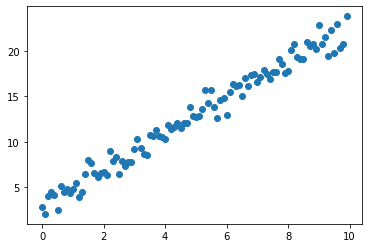

In [56]:
n = 100
start = 0
end   = 10
x = np.ones((n,2))
# preenche a coluna 1 com valores entre 0 e 1
x[:,1] = np.arange(start,end,(end-start)/n)

# vetor de pesos
theta = np.matrix([3.0,2.0])

#shuffle
sindex = np.arange(x.shape[0])
np.random.shuffle(sindex)
x=x[sindex]

# atributo classe
y = theta@x.T + np.random.randn(n).T
plt.scatter(x[:,1],y.tolist())

O gradiente descendente usa todos os exemplos a cada atualização, já o estocastico é aquele que faz atualização a cada exemplo.

[[6.63199637]] [[16.47781653  0.06918584]]
[[5.11654478]] [[13.60701694  0.44193728]]
[[3.92846075]] [[11.35636692  0.73416702]]
[[2.99702639]] [[9.59190187 0.96326935]]
[[2.26680031]] [[8.20859621 1.14288105]]
[[1.69431752]] [[7.12411197 1.28369305]]
[[1.24550234]] [[6.27389781 1.39408688]]
[[0.89364014]] [[5.60734674 1.48063346]]
[[0.61778714]] [[5.0847839  1.54848426]]
[[0.40152385]] [[4.67510498 1.60167794]]


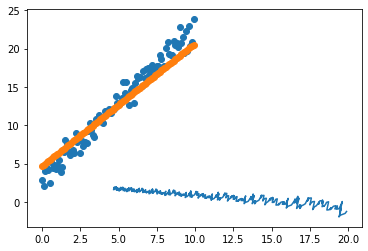

In [57]:
def estocastico():
  alpha = 0.01 #learning rate
  theta_hat = np.matrix([20.0,-1.0])#inicialização aleatória dos pesos
  stochastic = [] #vetor para desenhar a variação a cada atualização
  for epoch in range(10): #número de iterações
    for i in range(len(x)): #para cada exemplo, usar o GD e guardar no vetor tb
      #theta = theta - alpha * (theta * x^T - y) * x
      loss = theta_hat@x[i].T - y.T[i]
      theta_hat -= alpha * loss* x[i]
      stochastic.append(theta_hat.tolist().copy())
    print(loss,theta_hat)
  y_hat = theta_hat@x.T #predição
  plt.scatter(x[:,1], y.tolist())
  plt.scatter(x[:,1], y_hat.tolist())
  stochastic = np.array(stochastic)

  plt.plot(stochastic[:,0,0],stochastic[:,0,1])
  
if __name__ == '__main__':
  estocastico()

#Regressão Linear

##Download e import

In [58]:
!pip install scikit-learn==0.23

In [59]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Aquisição dos dados.

 Vamos usar o scikitlearn que já contem o dataset.

In [60]:
cal_housing = fetch_california_housing(as_frame=True)
df = cal_housing.data.copy()
X = cal_housing.data
y = cal_housing.target
df.insert(0,y.name,y)

In [61]:
df

,MedHouseVal,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,4.526,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,3.585,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,3.521,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,3.413,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.422,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,0.781,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,0.771,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,0.923,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,0.847,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


##Representação gráfica dos dados

###Desenhando mapa, com relação à alguns atributos

Como temos a latitude e longitude, seria muito legal conseguir visualizar os dados de uma maneira mais geográfica

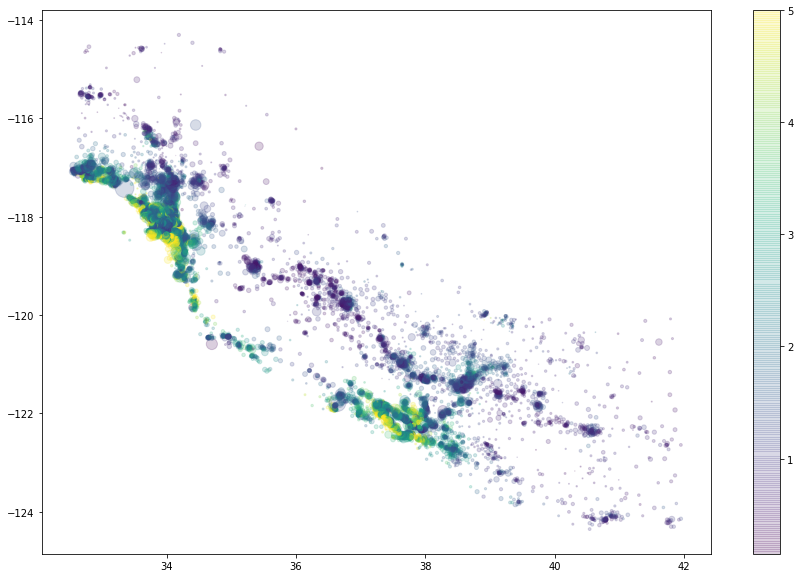

In [62]:
plt.figure(figsize=(15,10))
plt.scatter(df.Latitude, df.Longitude, alpha=0.2, c=df.MedHouseVal, s=df.Population/100)#x,y,transparência,cor,tamanho
plt.colorbar()

##Pré processamento

### Verificando se existem dados faltando

In [64]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Longitude,0,0.0
Latitude,0,0.0
AveOccup,0,0.0
Population,0,0.0
AveBedrms,0,0.0
AveRooms,0,0.0
HouseAge,0,0.0
MedInc,0,0.0
MedHouseVal,0,0.0


###Normalizando os dados


In [82]:
df[['AveRooms','MedHouseVal']].describe()

,AveRooms,MedHouseVal
count,20640.000000,20640.000000
mean,5.429000,2.068558
std,2.474173,1.153956
min,0.846154,0.149990
25%,4.440716,1.196000
50%,5.229129,1.797000
75%,6.052381,2.647250
max,141.909091,5.000010


In [83]:
#non_scaled = df.values#usa todas as features
non_scaled = df[['AveRooms','MedHouseVal']]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(non_scaled)
dfScaled = pd.DataFrame(scaled)
dfScaled.describe()

,0,1
count,20640.000000,20640.000000
mean,0.032488,0.395579
std,0.017539,0.237928
min,0.000000,0.000000
25%,0.025482,0.215671
50%,0.031071,0.339588
75%,0.036907,0.514897
max,1.000000,1.000000


##Treinando o modelo

In [84]:
#X_train, X_test, y_train, y_test = train_test_split(dfScaled.iloc[:,:-1].values, dfScaled.iloc[:,-1].values, test_size=0.2, random_state=0)#usa todas as features
X_train, X_test, y_train, y_test = train_test_split(dfScaled[0].values, dfScaled[1].values, test_size=0.2, random_state=0)

#Reshape requisitado pelo modelo quando só tem 1 feature
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [85]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [86]:
y_pred = regressor.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
regressor.score(X_test,y_test)

0.019686674517510827

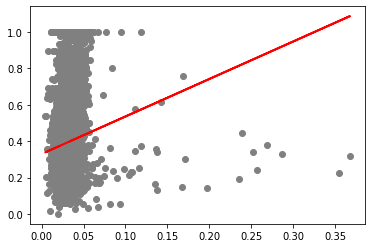

In [87]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

#Hora do trabalho
descubram qual o melhor atributo para usar na regressão

##***Resposta***

###Tabela de correlação

Procurando o atributo mais relevante para a nossa predição

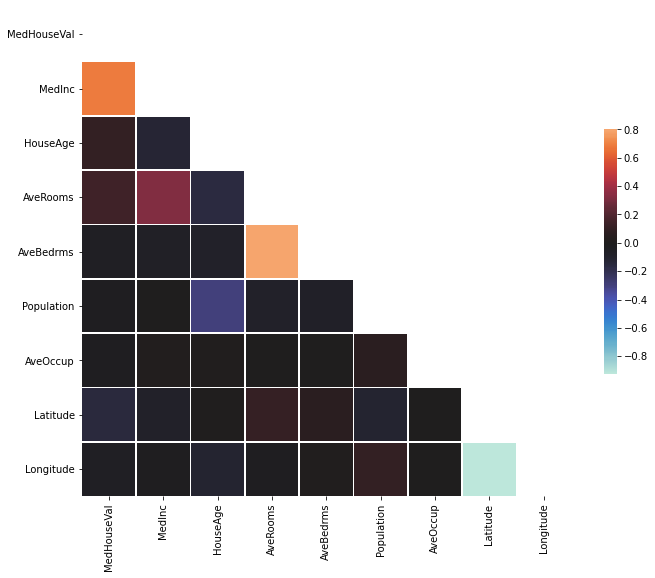

In [63]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))

mask = np.zeros_like(corrmat, dtype=np.bool)#mask para mostra só a matriz triangular inferior
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat, mask=mask, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) #desenho da matriz

Podemos perceber que a maior correlação é a com MedInc, que seria a renda, logo iremos utilizar essa feature para fazer a regressão linear

#Demonstração regressão multi-variável

A matemática aqui fica um pouco mais medonha, então vamos "ignorar" ela por fins de praticidade. Já sabemos como funciona pra 1, agora vamos ver o impacto que mais características do problema influenciam a ter um resultado melhor.

Vamos fazer a mesma normalização, mas sem cortar o dataset

In [71]:
#non_scaled = df.values#usa todas as features
non_scaled_all_feat = df.copy() #precisamos usar o .copy, senão recemos uma ref do df e alteramos o original
scaler = MinMaxScaler()
scaled = scaler.fit_transform(non_scaled_all_feat)
dfScaledAllFeat = pd.DataFrame(scaled)
dfScaledAllFeat.describe()

,0,1,2,3,4,5,6,7,8
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.395579,0.232464,0.541951,0.032488,0.022629,0.039869,0.001914,0.328572,0.476125
std,0.237928,0.131020,0.246776,0.017539,0.014049,0.031740,0.008358,0.226988,0.199555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.215671,0.142308,0.333333,0.025482,0.019943,0.021974,0.001398,0.147715,0.253984
50%,0.339588,0.209301,0.549020,0.031071,0.021209,0.032596,0.001711,0.182784,0.583665
75%,0.514897,0.292641,0.705882,0.036907,0.022713,0.048264,0.002084,0.549416,0.631474
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
X_train, X_test, y_train, y_test = train_test_split(dfScaledAllFeat.iloc[:,:-1].values, dfScaledAllFeat.iloc[:,-1].values, test_size=0.2, random_state=0)#usa todas as features

In [73]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [74]:
y_pred = regressor.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
regressor.score(X_test,y_test)

0.9019120225663235

Não conseguimos desenhar esse problema por que temos *n* dimensões, mas está claro que houve uma melhora, pois o melhor score possível que o regressor linear do scikit learn usa, é 1